In [1]:
from splender.image import SplenderImage
from splender.knot_init import get_splines_from_frame, downsample_points
from splender.optim import fit
import jax.random as random

import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [2]:
dat = np.loadtxt('mnist_train.csv', delimiter=',')

36
(8, 2)


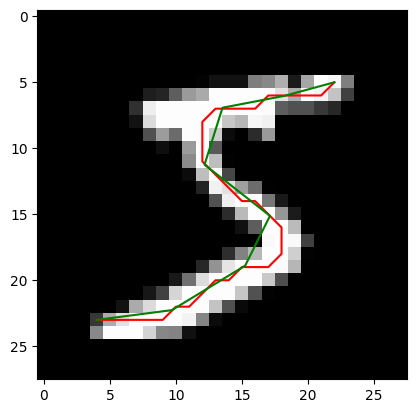

40
(8, 2)


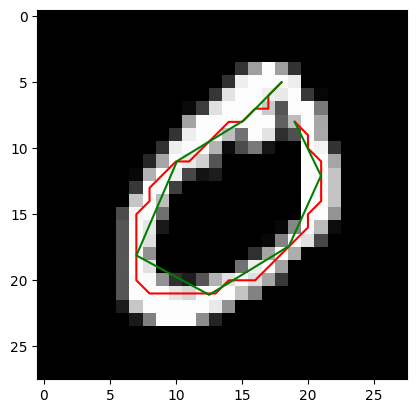

31
(8, 2)


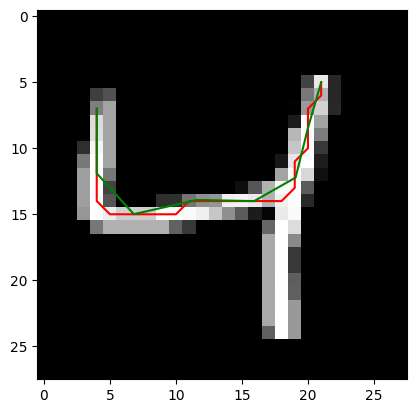

18
(8, 2)


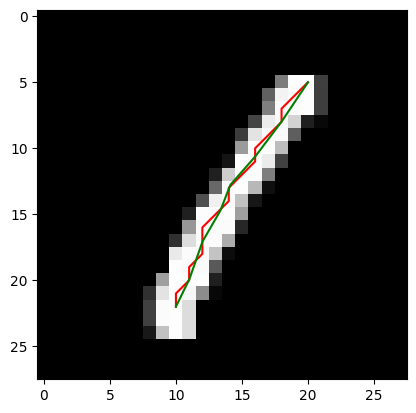

25
(8, 2)


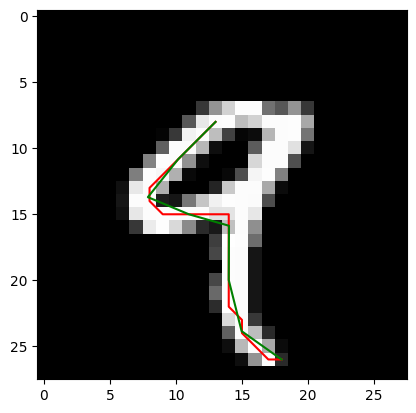

31
(8, 2)


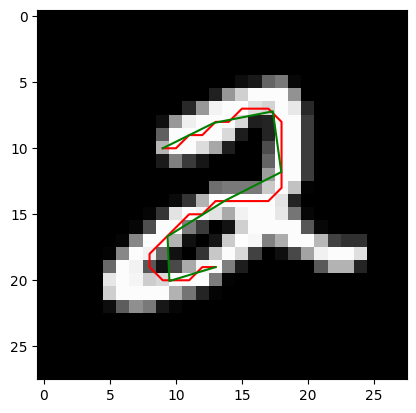

19
(8, 2)


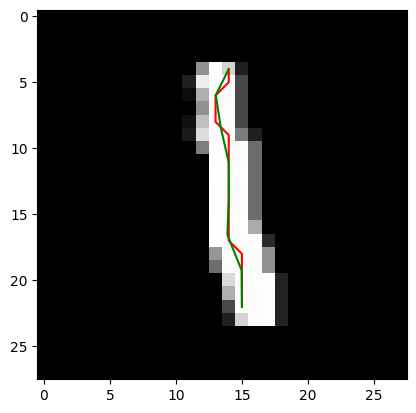

35
(8, 2)


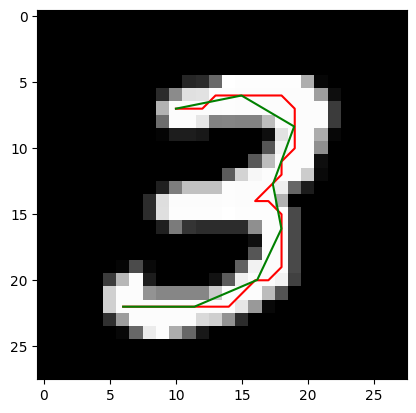

18
(8, 2)


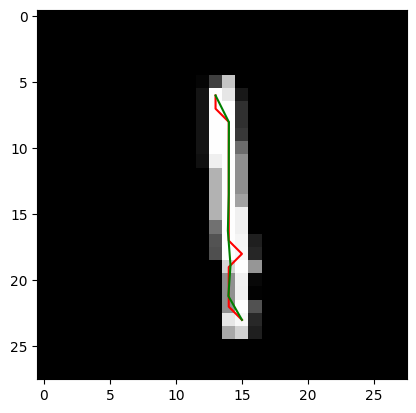

24
(8, 2)


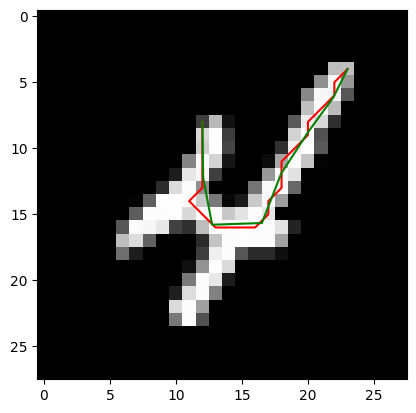

24
(8, 2)


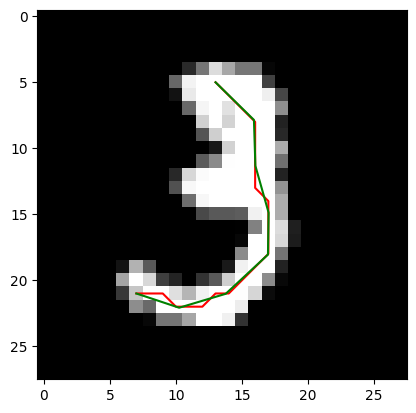

24
(8, 2)


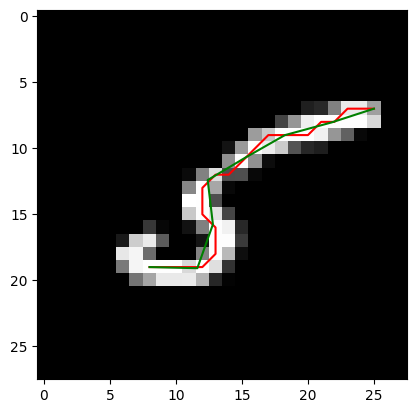

In [3]:
n_images = 12
images = []
init_splines = []
for i in range(n_images):
    img = dat[i, 1:].reshape(28, 28)
    img = img / 255.0
    images.append(img)
    path = get_splines_from_frame(img, 0.1)[0][:, ::-1]
    print(len(path))
    init_spline = np.array(path).astype(np.float32)
    init_spline = downsample_points(init_spline)
    init_splines.append(init_spline[None])
    print(init_spline.shape)
    plt.imshow(img, cmap='gray')
    plt.plot(path[:, 0], path[:, 1], 'r-')
    plt.plot(init_spline[:, 0], init_spline[:, 1], 'g-')
    plt.show()

In [4]:
images = jnp.array(images)

In [5]:
init_splines = jnp.array(init_splines) / 28

In [6]:
# model = SplenderImage(random.PRNGKey(0), init_splines, res = 28)
model = SplenderImage(key = random.PRNGKey(0), init_knots=init_splines, res=28, global_scale = 0.3)

In [7]:
model, losses = fit(model, images)

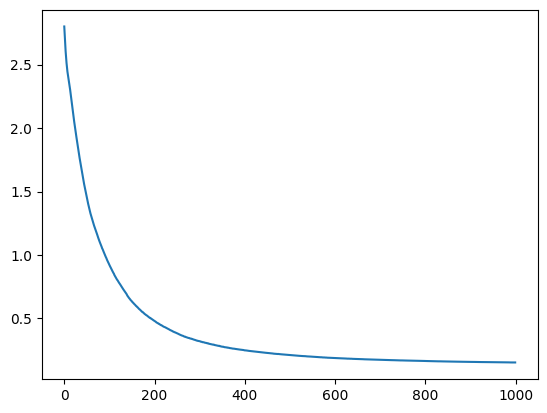

In [8]:
plt.plot(losses)
# plt.ylim(0.0665, 0.0668)

In [9]:
ims, lengths, curvatures = model()

In [14]:
ims.shape

(12, 28, 28)

In [11]:
xy_splines = [model.fit_spline(model.loc_params[i, 0] + model.knot_params[i, 0])[:2] for i in range(12)]

In [12]:
xy_splines[0]

(Interpolator1D(
   x=f32[8],
   f=f32[8],
   derivs={'fx': f32[8]},
   method='cubic2',
   extrap=False,
   period=None,
   axis=0
 ),
 Interpolator1D(
   x=f32[8],
   f=f32[8],
   derivs={'fx': f32[8]},
   method='cubic2',
   extrap=False,
   period=None,
   axis=0
 ))

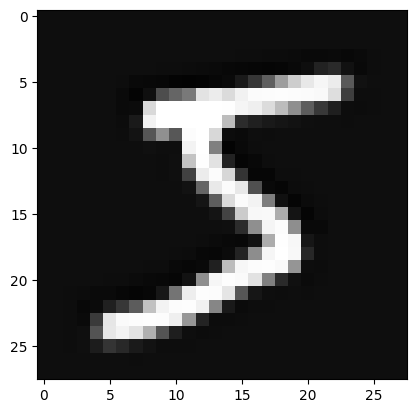

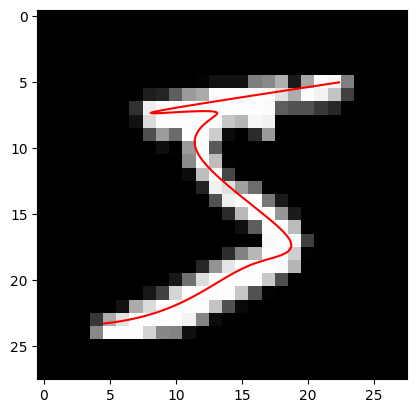

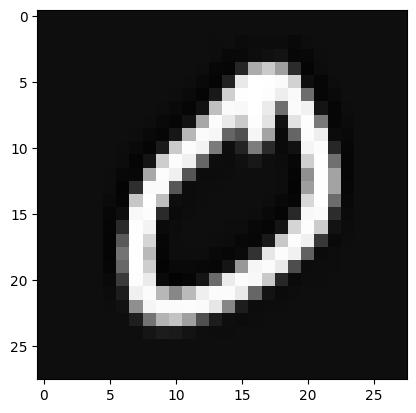

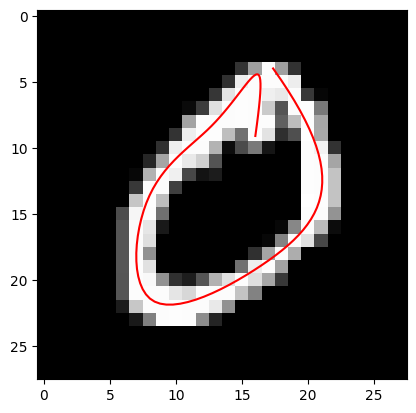

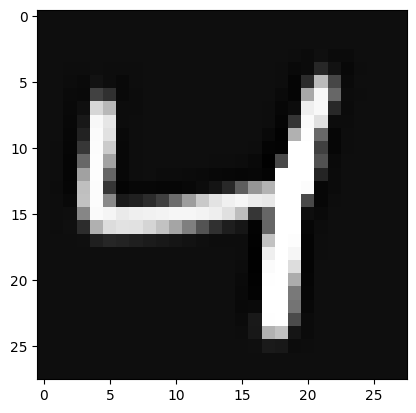

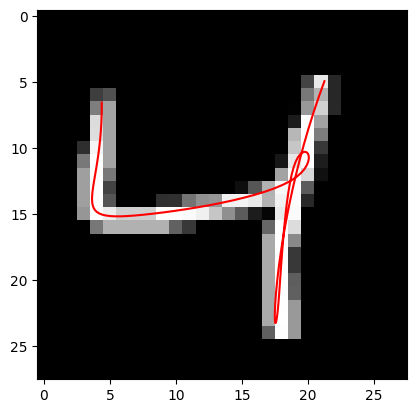

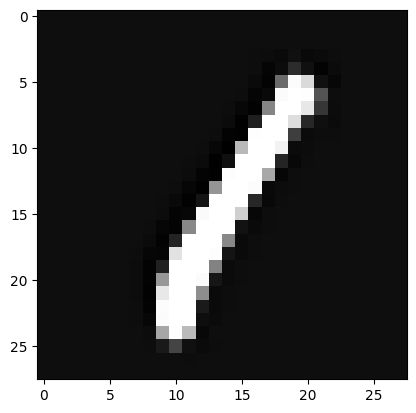

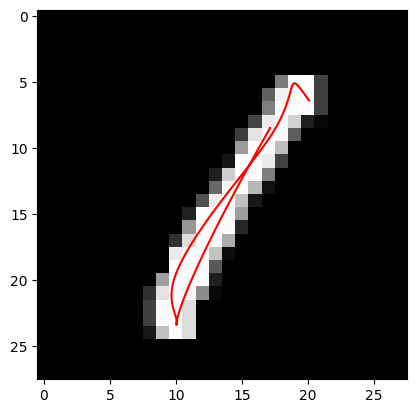

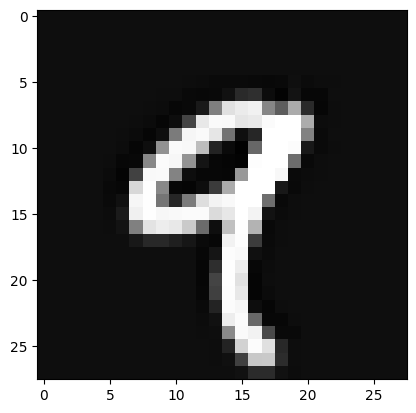

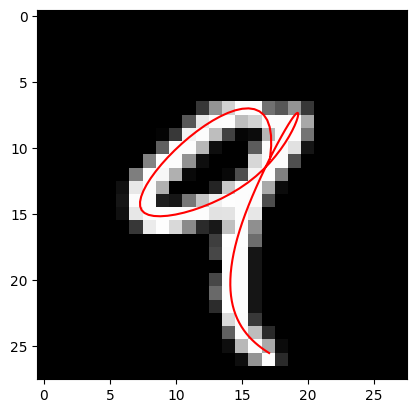

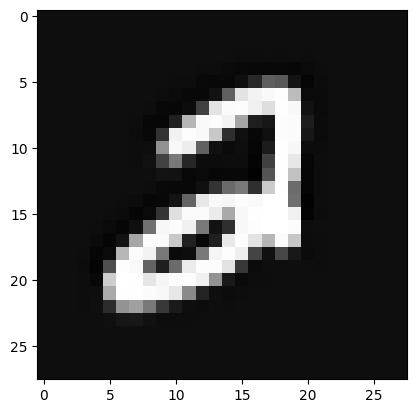

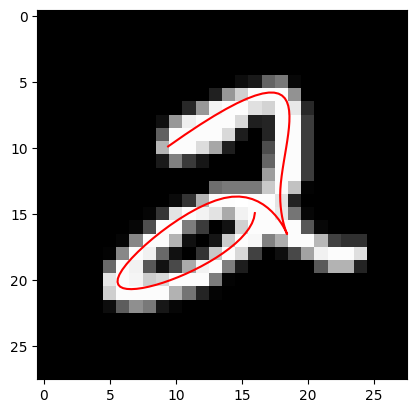

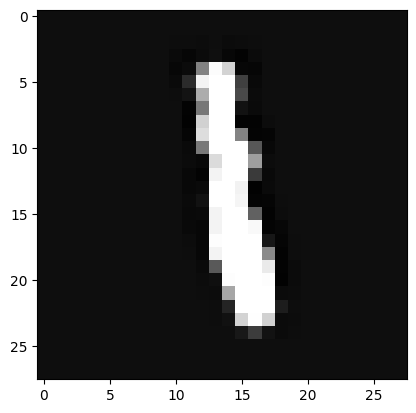

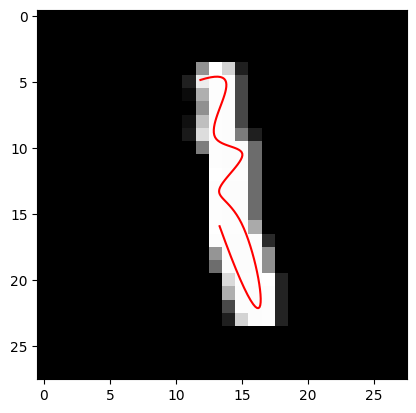

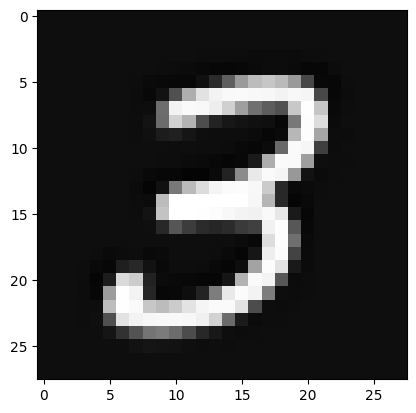

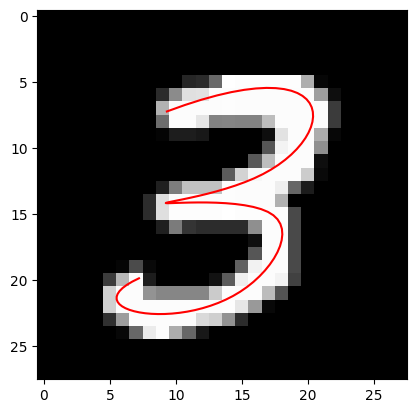

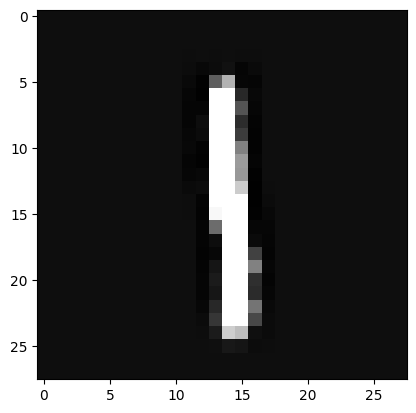

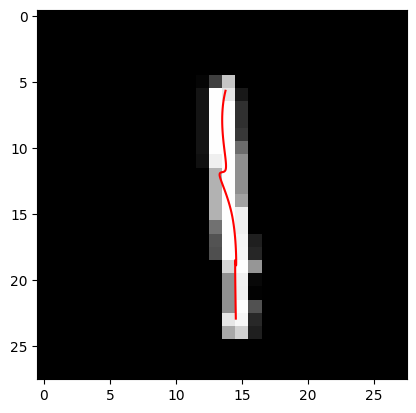

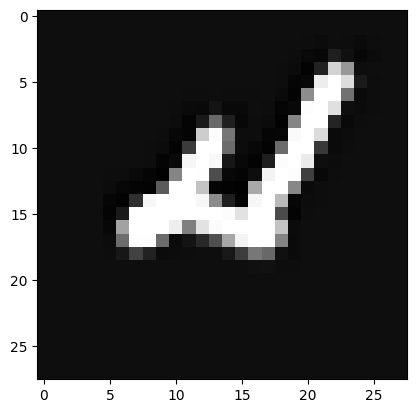

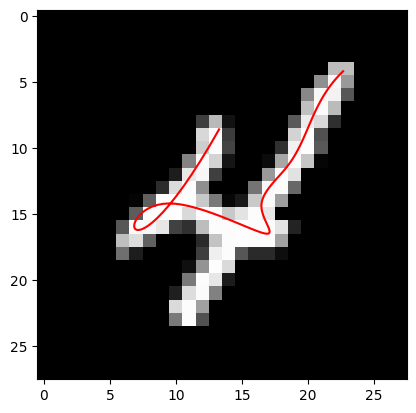

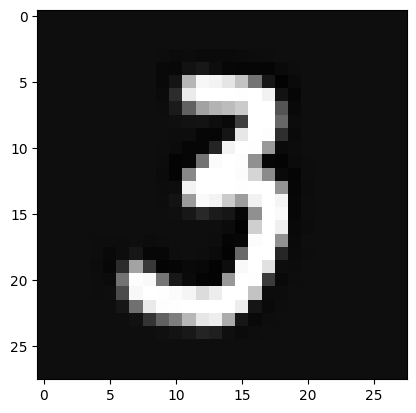

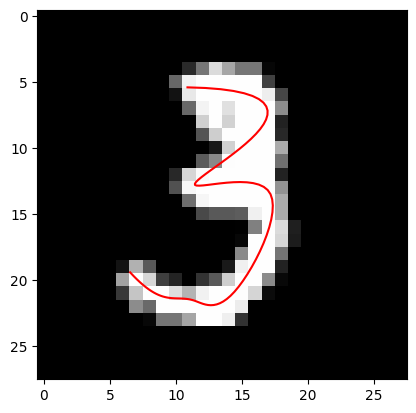

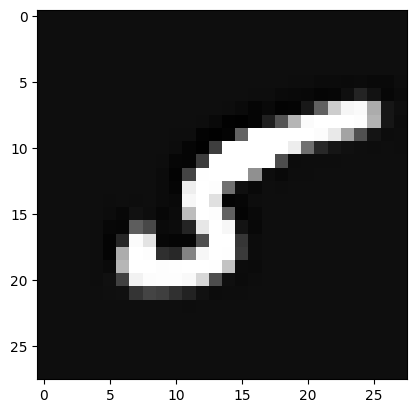

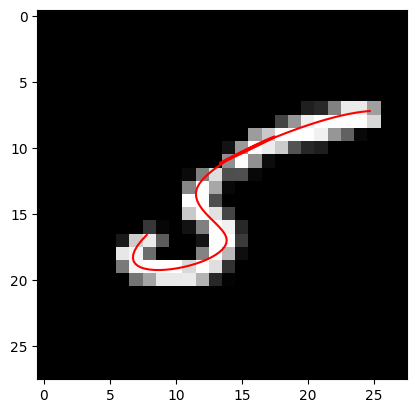

In [13]:
for i in range(n_images):
    plt.imshow(ims[i], cmap='gray', vmin=0, vmax=1)
    plt.show()
    plt.imshow(images[i], cmap='gray', vmin=0, vmax=1)
    plt.plot(model.res * xy_splines[i][0](jnp.linspace(0, 1, 100)), model.res * xy_splines[i][1](jnp.linspace(0, 1, 100)), c='r')
    plt.show()